<a href="https://colab.research.google.com/github/PondKann/CXR_classification_model/blob/main/Inception_Train_Test_2class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Pretrained // Sampling Abnormal   รันแล้ว

2) 0-100 // Sampling Abnormal  รันแล้ว

#### import

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import numpy as np
import pandas as pd
from torchsummary import summary
from skimage.io import imread, imsave
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import PIL
from PIL import Image


In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from imutils import paths
import argparse

from sklearn.model_selection import KFold
from sklearn import metrics
from scipy.stats import zscore


import matplotlib.image as mpimg
from matplotlib.pyplot import savefig

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#### Load data // KKU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class/Image'

train 3 class

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

#### Load data // Gmail

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class'

train 3 class

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

#### Data 2 class  + Sampling data
ข้อมูลใน All_3class_dir รวมภาพทั้ง 3 คลาส รวม 451 ภาพ TB150, Normal151 และ CA150 (CA คือ lungcancer)

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

In [ ]:
normal = []
for i in range(len(os.listdir(Normal151_dir))):
    img = os.listdir(Normal151_dir)[i]
    normal.append(img)
    
tnormal = pd.DataFrame({'ImageName':[normal][0],
                                       'NameType': "Normal"  })

In [ ]:
tuberculosis = []
for i in range(len(os.listdir(TB150_dir))):
    img = os.listdir(TB150_dir)[i]
    tuberculosis.append(img)

ttuberculosis = pd.DataFrame({'ImageName':[tuberculosis][0],
                                       'NameType': "Abnormal"  })

In [ ]:
lungcancer = []
for i in range(len(os.listdir(CA150_dir))):
    img = os.listdir(CA150_dir)[i]
    lungcancer.append(img)

tlungcancer = pd.DataFrame({'ImageName':[lungcancer][0],
                                       'NameType': "Abnormal"  })

In [ ]:
data_train3 = pd.concat([tnormal[:-1], ttuberculosis, tlungcancer])
data_train3[-3:]

,ImageName,NameType
147,ca26.jpg,Abnormal
148,ca7.jpg,Abnormal
149,ca2.jpg,Abnormal


In [ ]:
data_train3.shape

(450, 2)

Sampling data

In [ ]:
tabnormal= pd.concat([ttuberculosis, tlungcancer])
tabnormal = tabnormal.sample(n=150, random_state=40)
data_train3 = pd.concat([tnormal[:-1], tabnormal])

In [ ]:
data_train3.to_excel("data_2class_sampling.xlsx")

## Pretrained Sampling Abnormal

#### 1 sig pre bi sgd
0.84

In [ ]:
BS = 1
filepath = "model1_sig_pre_bi_sgd.h5"                  ##
filename = f" {filepath}.h5 "

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=2)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                          
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:06<00:00, 49.80it/s]


In [ ]:
(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # unit 2
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)
                                                ###
model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_Incep.argmax(axis=1), target_names=le_Incep.classes_))


# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download(filepath)     

Epoch 1/100
224/225 [============================>.] - ETA: 0s - loss: 0.7160 - accuracy: 0.4866
Epoch 1: val_accuracy improved from -inf to 0.50667, saving model to model1_sig_pre_bi_sgd.h5
225/225 [==============================] - 20s 55ms/step - loss: 0.7157 - accuracy: 0.4889 - val_loss: 0.7027 - val_accuracy: 0.5067 - lr: 1.0000e-04
Epoch 2/100
224/225 [============================>.] - ETA: 0s - loss: 0.7144 - accuracy: 0.4509
Epoch 2: val_accuracy improved from 0.50667 to 0.56000, saving model to model1_sig_pre_bi_sgd.h5
225/225 [==============================] - 10s 45ms/step - loss: 0.7139 - accuracy: 0.4533 - val_loss: 0.6938 - val_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 3/100
224/225 [============================>.] - ETA: 0s - loss: 0.7070 - accuracy: 0.4643
Epoch 3: val_accuracy improved from 0.56000 to 0.60000, saving model to model1_sig_pre_bi_sgd.h5
225/225 [==============================] - 11s 48ms/step - loss: 0.7060 - accuracy: 0.4667 - val_loss: 0.6875 - val_accur

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

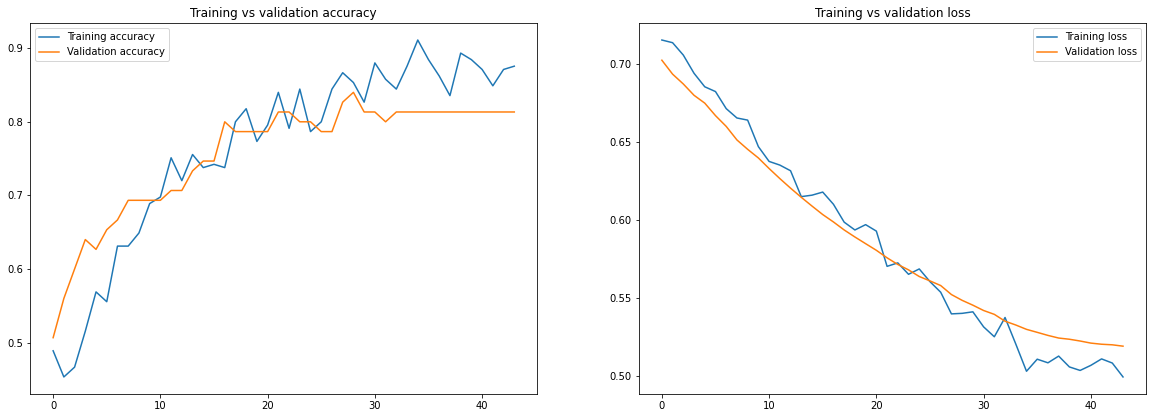

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[22 13]
 [ 1 39]]
Normalized confusion matrix
[[0.63 0.37]
 [0.03 0.97]]


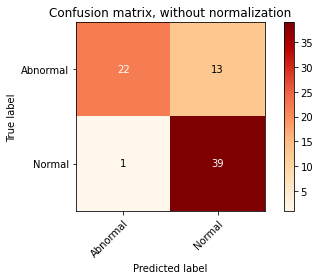

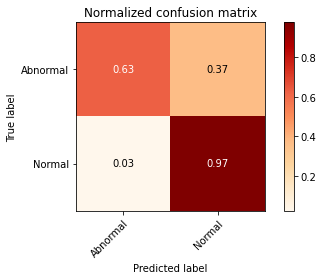

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
model.save(filename)

INFO:tensorflow:Assets written to:  model1_sig_pre_bi_sgd.h5.h5 /assets


In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

    Abnormal       0.93      0.71      0.81        35
      Normal       0.79      0.95      0.86        40

    accuracy                           0.84        75
   macro avg       0.86      0.83      0.84        75
weighted avg       0.85      0.84      0.84        75



Confusion matrix, without normalization
[[25 10]
 [ 2 38]]
Normalized confusion matrix
[[0.71 0.29]
 [0.05 0.95]]


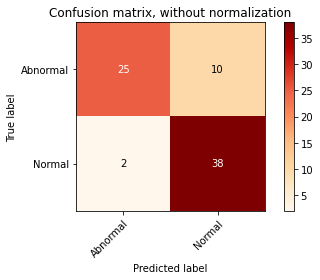

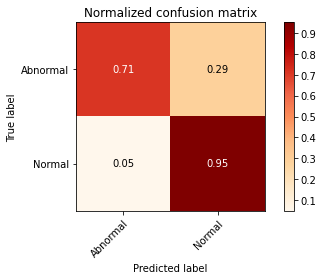

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

####  8 sig pre bi 
0.85


In [ ]:
BS = 8
filepath = "model8_sig_pre_bi.h5"                  ##
filename = f" {filepath}.h5 "

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=2)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                          
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:03<00:00, 90.80it/s]


In [ ]:
(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # unit 2
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)
                                                ###
model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_Incep.argmax(axis=1), target_names=le_Incep.classes_))


#download ไฟล์ลงเครื่อง
from google.colab import files
files.download(filepath)     

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.6221
Epoch 1: val_accuracy did not improve from 0.77333
28/28 [==============================] - 18s 319ms/step - loss: 0.6728 - accuracy: 0.6221 - val_loss: 0.6907 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.6452
Epoch 2: val_accuracy did not improve from 0.77333
28/28 [==============================] - 6s 221ms/step - loss: 0.6415 - accuracy: 0.6452 - val_loss: 0.6616 - val_accuracy: 0.6533 - lr: 1.0000e-04
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.7650
Epoch 3: val_accuracy did not improve from 0.77333
28/28 [==============================] - 6s 222ms/step - loss: 0.6393 - accuracy: 0.7650 - val_loss: 0.6506 - val_accuracy: 0.6933 - lr: 1.0000e-04
Epoch 4/100
28/28 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.7512
Epoch 4: val_accuracy 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

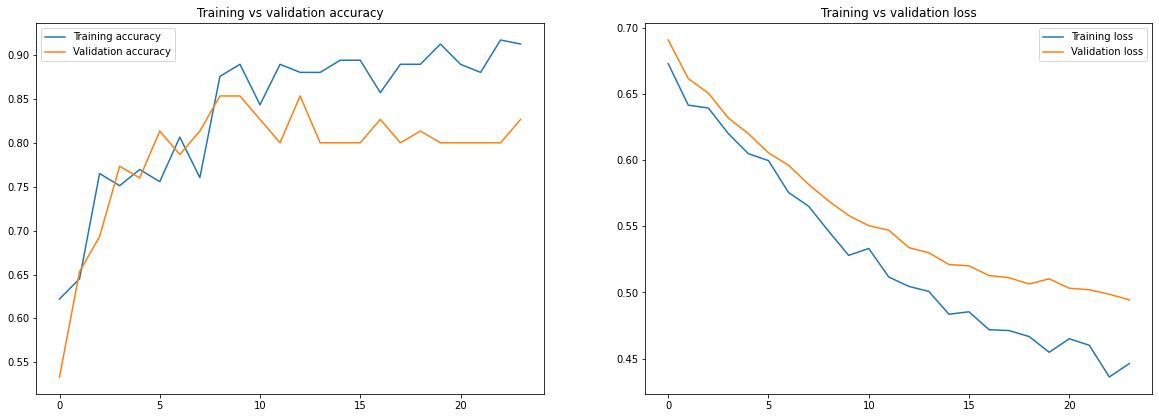

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[22 13]
 [ 0 40]]
Normalized confusion matrix
[[0.63 0.37]
 [0.   1.  ]]


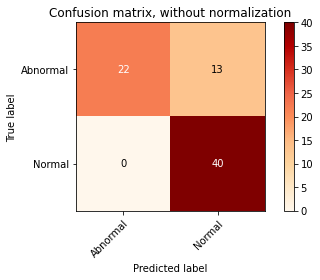

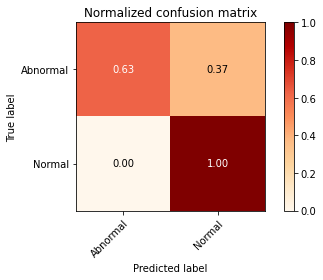

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

    Abnormal       0.90      0.77      0.83        35
      Normal       0.82      0.93      0.87        40

    accuracy                           0.85        75
   macro avg       0.86      0.85      0.85        75
weighted avg       0.86      0.85      0.85        75



Confusion matrix, without normalization
[[27  8]
 [ 3 37]]
Normalized confusion matrix
[[0.77 0.23]
 [0.07 0.93]]


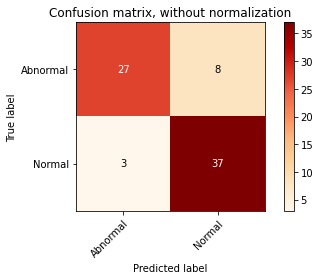

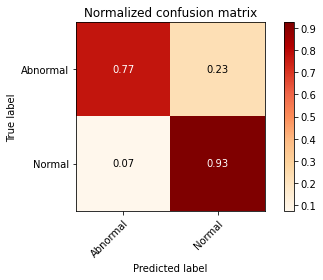

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 sig pre bi adam
0.85


In [ ]:
BS = 16
filepath = "model16_sig_pre_bi_adam.h5"                  ##
filename = f" {filepath}.h5 "

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=2)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                          
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:03<00:00, 88.71it/s]


In [ ]:
(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # unit 2
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)
                                                ###
model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_Incep.argmax(axis=1), target_names=le_Incep.classes_))


#download ไฟล์ลงเครื่อง
from google.colab import files
files.download(filepath)     

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5550
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to model16_sig_pre_bi_adam.h5
14/14 [==============================] - 13s 574ms/step - loss: 0.6934 - accuracy: 0.5550 - val_loss: 0.6749 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.6603
Epoch 2: val_accuracy improved from 0.60000 to 0.68000, saving model to model16_sig_pre_bi_adam.h5
14/14 [==============================] - 6s 454ms/step - loss: 0.6659 - accuracy: 0.6603 - val_loss: 0.6621 - val_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.5837
Epoch 3: val_accuracy did not improve from 0.68000
14/14 [==============================] - 6s 391ms/step - loss: 0.6619 - accuracy: 0.5837 - val_loss: 0.6613 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 4/100
14/14 [=====

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

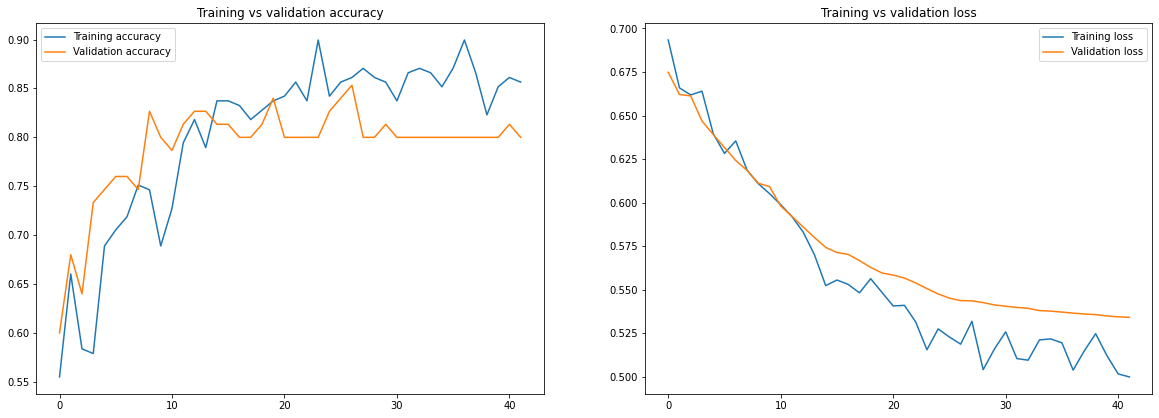

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[20 15]
 [ 0 40]]
Normalized confusion matrix
[[0.57 0.43]
 [0.   1.  ]]


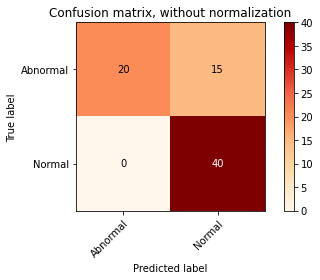

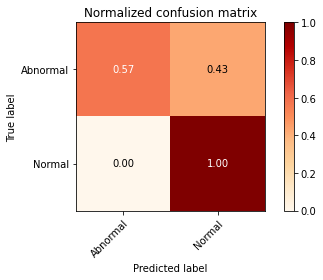

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

    Abnormal       1.00      0.69      0.81        35
      Normal       0.78      1.00      0.88        40

    accuracy                           0.85        75
   macro avg       0.89      0.84      0.85        75
weighted avg       0.88      0.85      0.85        75



Confusion matrix, without normalization
[[24 11]
 [ 0 40]]
Normalized confusion matrix
[[0.69 0.31]
 [0.   1.  ]]


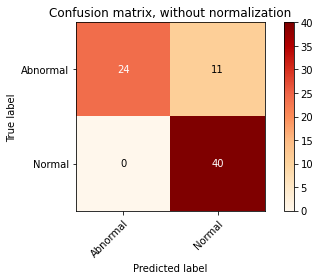

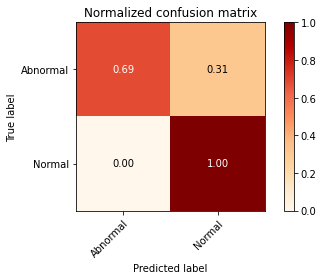

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 sig pre bi sgd
0.52


In [ ]:
BS = 16
filepath = "model16_sig_pre_bi_sgd.h5"                  ##

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=2)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                          
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:03<00:00, 87.95it/s]


In [ ]:
(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # unit 2
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)
                                                ###
model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_Incep.argmax(axis=1), target_names=le_Incep.classes_))


# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download(filepath)     

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.7709 - accuracy: 0.5024
Epoch 1: val_accuracy improved from -inf to 0.45333, saving model to model16_sig_pre_bi_sgd.h5
14/14 [==============================] - 14s 597ms/step - loss: 0.7709 - accuracy: 0.5024 - val_loss: 0.7965 - val_accuracy: 0.4533 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.7651 - accuracy: 0.4976
Epoch 2: val_accuracy improved from 0.45333 to 0.46667, saving model to model16_sig_pre_bi_sgd.h5
14/14 [==============================] - 7s 501ms/step - loss: 0.7651 - accuracy: 0.4976 - val_loss: 0.7875 - val_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.7526 - accuracy: 0.5024
Epoch 3: val_accuracy did not improve from 0.46667
14/14 [==============================] - 6s 409ms/step - loss: 0.7526 - accuracy: 0.5024 - val_loss: 0.7823 - val_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 4/100
14/14 [=======

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

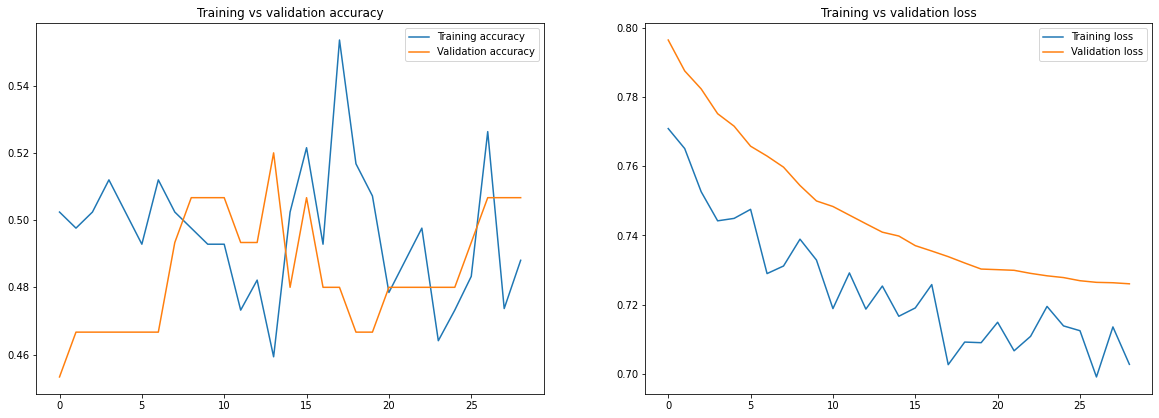

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[22 13]
 [24 16]]
Normalized confusion matrix
[[0.63 0.37]
 [0.6  0.4 ]]


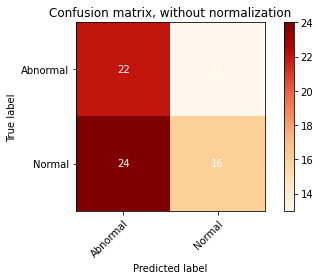

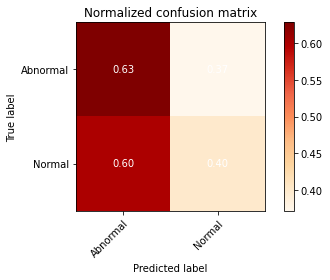

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

    Abnormal       0.49      0.89      0.63        35
      Normal       0.67      0.20      0.31        40

    accuracy                           0.52        75
   macro avg       0.58      0.54      0.47        75
weighted avg       0.59      0.52      0.46        75



Confusion matrix, without normalization
[[31  4]
 [32  8]]
Normalized confusion matrix
[[0.89 0.11]
 [0.8  0.2 ]]


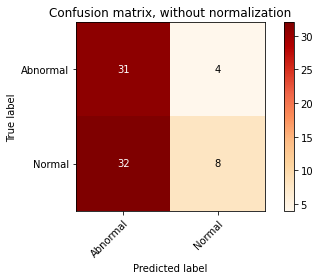

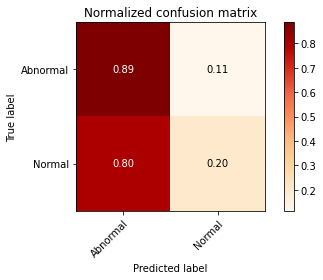

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 sig pre bi 
0.84


In [ ]:
BS = 32
filepath = "model32_sig_pre_bi.h5"                  ##
filename = f" {filepath}.h5 "

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=2)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                          
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:03<00:00, 91.24it/s]


In [ ]:
(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # unit 2
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)
                                                ###
model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_Incep.argmax(axis=1), target_names=le_Incep.classes_))


# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download(filepath)     

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.5026
Epoch 1: val_accuracy improved from -inf to 0.46667, saving model to model32_sig_pre_bi.h5
7/7 [==============================] - 13s 1s/step - loss: 0.7406 - accuracy: 0.5026 - val_loss: 0.7387 - val_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.4197
Epoch 2: val_accuracy improved from 0.46667 to 0.48000, saving model to model32_sig_pre_bi.h5
7/7 [==============================] - 6s 876ms/step - loss: 0.7291 - accuracy: 0.4197 - val_loss: 0.7083 - val_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.4301
Epoch 3: val_accuracy improved from 0.48000 to 0.50667, saving model to model32_sig_pre_bi.h5
7/7 [==============================] - 6s 984ms/step - loss: 0.7225 - accuracy: 0.4301 - val_loss: 0.6982 - val_accuracy: 0.5067 - lr: 1.0000e-04
Epoch 

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

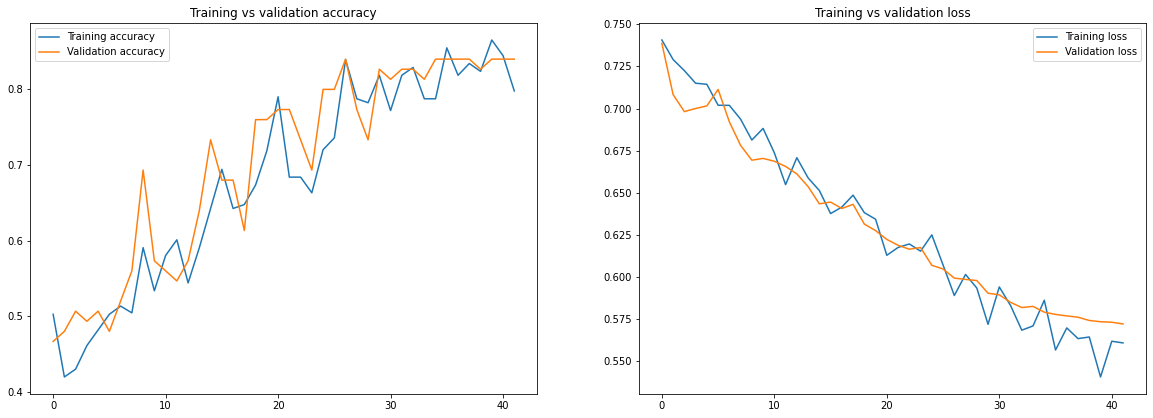

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[24 11]
 [ 1 39]]
Normalized confusion matrix
[[0.69 0.31]
 [0.03 0.97]]


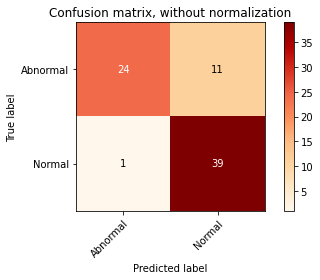

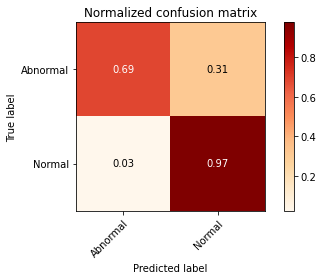

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

    Abnormal       0.96      0.69      0.80        35
      Normal       0.78      0.97      0.87        40

    accuracy                           0.84        75
   macro avg       0.87      0.83      0.83        75
weighted avg       0.86      0.84      0.84        75



Confusion matrix, without normalization
[[24 11]
 [ 1 39]]
Normalized confusion matrix
[[0.69 0.31]
 [0.03 0.97]]


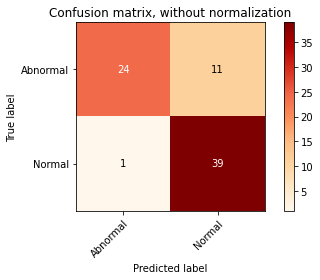

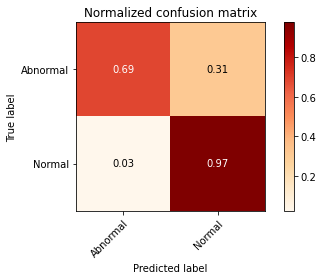

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## 0-100 Sampling Abnormal

#### 1 sig fine bi sgd
0.60


In [ ]:
BS = 1
filepath = "model1_sig_fine_bi_sgd.h5"                  ##
filename = f" {filepath}.h5 "

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=2)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                          
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:03<00:00, 88.38it/s]


In [ ]:
(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # unit 2
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)
                                                ###
model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_Incep.argmax(axis=1), target_names=le_Incep.classes_))


# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download(filepath)     

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: 0.7022 - accuracy: 0.5111
Epoch 1: val_accuracy improved from -inf to 0.52000, saving model to model1_sig_fine_bi_sgd.h5
225/225 [==============================] - 28s 89ms/step - loss: 0.7022 - accuracy: 0.5111 - val_loss: 0.7105 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.5111
Epoch 2: val_accuracy improved from 0.52000 to 0.57333, saving model to model1_sig_fine_bi_sgd.h5
225/225 [==============================] - 17s 77ms/step - loss: 0.6961 - accuracy: 0.5111 - val_loss: 0.7023 - val_accuracy: 0.5733 - lr: 1.0000e-04
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.5022
Epoch 3: val_accuracy did not improve from 0.57333
225/225 [==============================] - 16s 73ms/step - loss: 0.6965 - accuracy: 0.5022 - val_loss: 0.7049 - val_accuracy: 0.5467 - lr: 1.0000e-04
Epoch 4/100
225

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

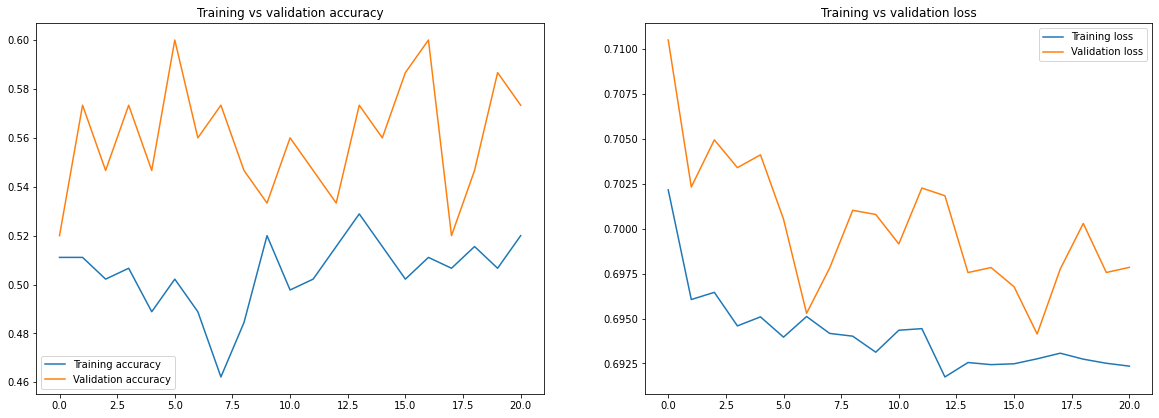

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[24 11]
 [21 19]]
Normalized confusion matrix
[[0.69 0.31]
 [0.53 0.47]]


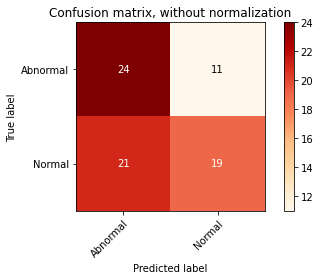

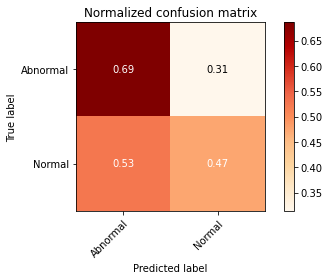

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

    Abnormal       0.56      0.69      0.62        35
      Normal       0.66      0.53      0.58        40

    accuracy                           0.60        75
   macro avg       0.61      0.61      0.60        75
weighted avg       0.61      0.60      0.60        75



Confusion matrix, without normalization
[[24 11]
 [19 21]]
Normalized confusion matrix
[[0.69 0.31]
 [0.47 0.53]]


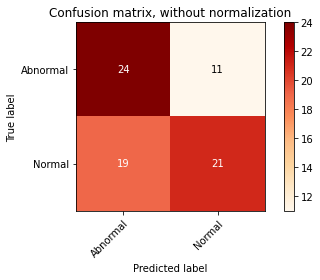

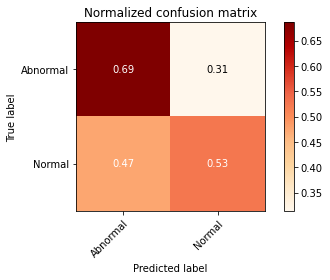

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 sig fine bi sgd
0.64


In [ ]:
BS = 8
filepath = "model8_sig_fine_bi_sgd.h5"                  ##
filename = f" {filepath}.h5 "

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=2)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                          
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:03<00:00, 94.92it/s]


In [ ]:
(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # unit 2
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)
                                                ###
model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_Incep.argmax(axis=1), target_names=le_Incep.classes_))


# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download(filepath)     

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.7075 - accuracy: 0.4885
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to model8_sig_fine_bi_sgd.h5
28/28 [==============================] - 17s 345ms/step - loss: 0.7075 - accuracy: 0.4885 - val_loss: 0.6853 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.5115
Epoch 2: val_accuracy improved from 0.53333 to 0.56000, saving model to model8_sig_fine_bi_sgd.h5
28/28 [==============================] - 8s 289ms/step - loss: 0.6984 - accuracy: 0.5115 - val_loss: 0.6893 - val_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.5530
Epoch 3: val_accuracy did not improve from 0.56000
28/28 [==============================] - 7s 260ms/step - loss: 0.6951 - accuracy: 0.5530 - val_loss: 0.7004 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 4/100
28/28 [=======

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

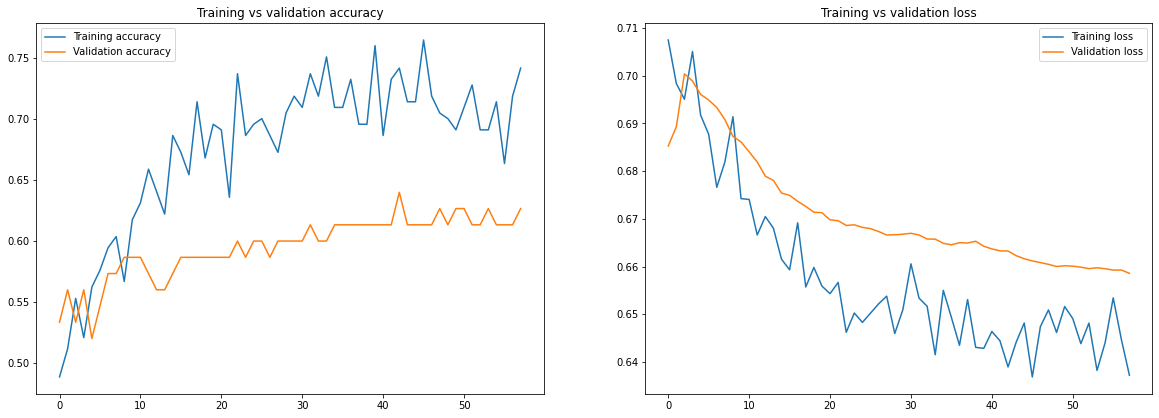

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[14 21]
 [ 7 33]]
Normalized confusion matrix
[[0.4  0.6 ]
 [0.17 0.82]]


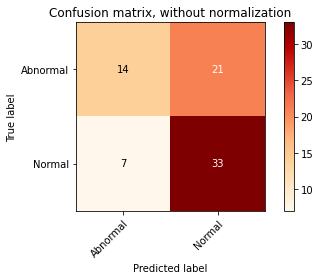

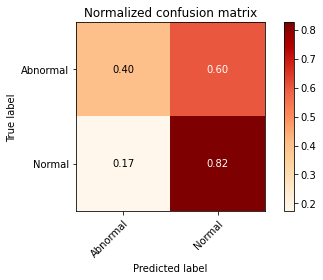

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

    Abnormal       0.67      0.46      0.54        35
      Normal       0.63      0.80      0.70        40

    accuracy                           0.64        75
   macro avg       0.65      0.63      0.62        75
weighted avg       0.65      0.64      0.63        75



Confusion matrix, without normalization
[[16 19]
 [ 8 32]]
Normalized confusion matrix
[[0.46 0.54]
 [0.2  0.8 ]]


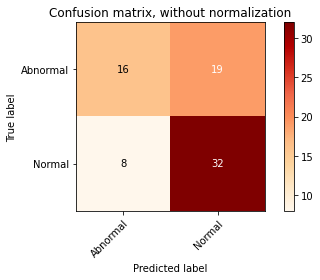

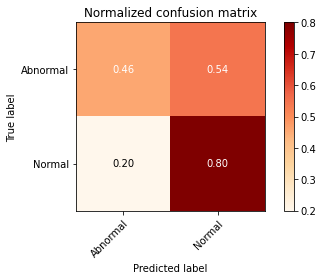

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 sig fine bi 
0.96


In [ ]:
BS = 16
filepath = "model16_sig_fine_bi.h5"                  ##
filename = f" {filepath}.h5 "

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=2)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                          
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:03<00:00, 91.61it/s]


In [ ]:
(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # unit 2
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)
                                                ###
model_Incep.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_Incep.argmax(axis=1), target_names=le_Incep.classes_))


# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download(filepath)     

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.8756
Epoch 1: val_accuracy improved from -inf to 0.56000, saving model to model16_sig_fine_bi.h5
14/14 [==============================] - 24s 698ms/step - loss: 0.3147 - accuracy: 0.8756 - val_loss: 0.9727 - val_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9234
Epoch 2: val_accuracy did not improve from 0.56000
14/14 [==============================] - 7s 485ms/step - loss: 0.2026 - accuracy: 0.9234 - val_loss: 1.7109 - val_accuracy: 0.5467 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9569
Epoch 3: val_accuracy improved from 0.56000 to 0.58667, saving model to model16_sig_fine_bi.h5
14/14 [==============================] - 8s 579ms/step - loss: 0.1019 - accuracy: 0.9569 - val_loss: 1.2539 - val_accuracy: 0.5867 - lr: 1.0000e-04
Epoch 4/100
14/14 [=============

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

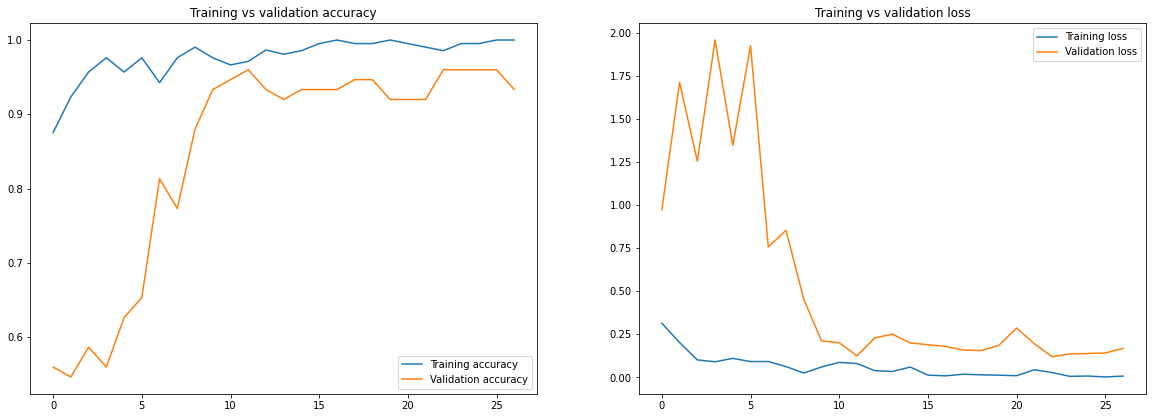

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[31  4]
 [ 1 39]]
Normalized confusion matrix
[[0.89 0.11]
 [0.03 0.97]]


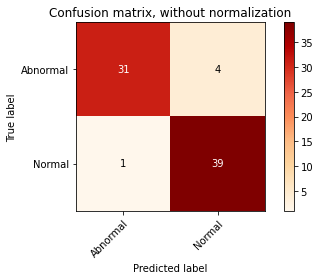

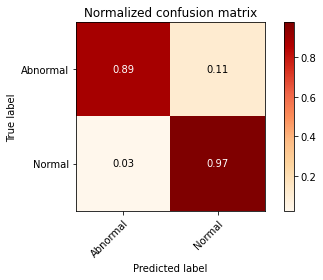

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

    Abnormal       0.94      0.97      0.96        35
      Normal       0.97      0.95      0.96        40

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



Confusion matrix, without normalization
[[34  1]
 [ 2 38]]
Normalized confusion matrix
[[0.97 0.03]
 [0.05 0.95]]


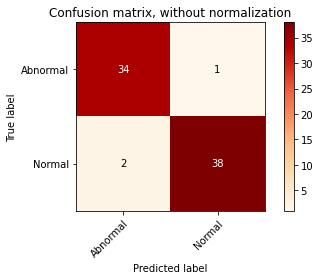

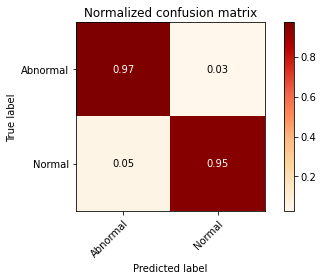

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 sig fine bi adam
0.987


In [ ]:
BS = 16
filepath = "model16_sig_fine_bi_adam.h5"                  ##
filename = f" {filepath}.h5 "

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=2)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                          
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:03<00:00, 92.68it/s]


In [ ]:
(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # unit 2
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)
                                                ###
model_Incep.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_Incep.argmax(axis=1), target_names=le_Incep.classes_))


# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download(filepath)     

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.4658 - accuracy: 0.7799
Epoch 1: val_accuracy improved from -inf to 0.61333, saving model to model16_sig_fine_bi_adam.h5
14/14 [==============================] - 17s 721ms/step - loss: 0.4658 - accuracy: 0.7799 - val_loss: 0.6875 - val_accuracy: 0.6133 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9509
Epoch 2: val_accuracy did not improve from 0.61333
14/14 [==============================] - 7s 495ms/step - loss: 0.1605 - accuracy: 0.9509 - val_loss: 0.8728 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9282
Epoch 3: val_accuracy did not improve from 0.61333
14/14 [==============================] - 7s 482ms/step - loss: 0.2077 - accuracy: 0.9282 - val_loss: 1.1640 - val_accuracy: 0.5733 - lr: 1.0000e-04
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 0.

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

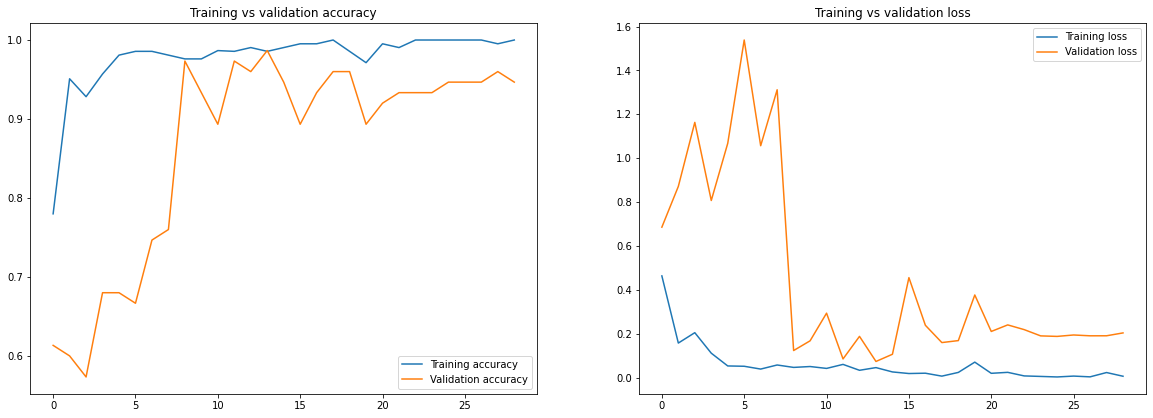

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[34  1]
 [ 3 37]]
Normalized confusion matrix
[[0.97 0.03]
 [0.07 0.93]]


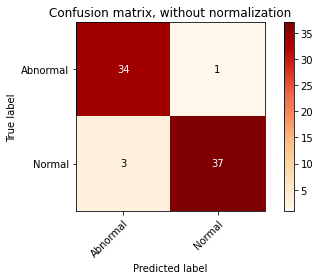

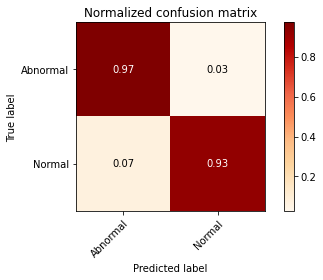

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

    Abnormal       0.97      1.00      0.99        35
      Normal       1.00      0.97      0.99        40

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



Confusion matrix, without normalization
[[35  0]
 [ 1 39]]
Normalized confusion matrix
[[1.   0.  ]
 [0.03 0.97]]


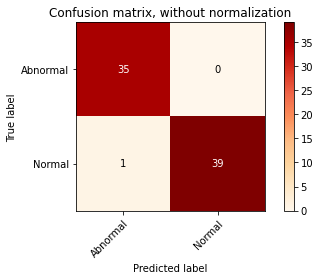

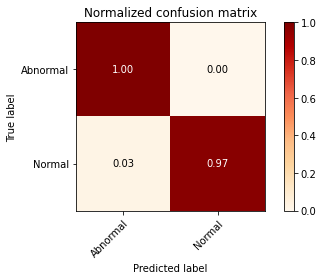

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 sig fine bi sgd
0.60


In [ ]:
BS = 16
filepath = "model16_sig_fine_bi_sgd.h5"                  ##
filename = f" {filepath}.h5 "

train_img_Incep = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (299, 299))                                      
    train_img_Incep.append(img)
data_Incep = np.array(train_img_Incep, dtype="float32") / 255.0

labels_Incep = np.array(data_train3[['NameType']] )        
labels_Incep.shape = (len(labels_Incep),) 
le_Incep = LabelEncoder()                                                                     
labels_Incep = le_Incep.fit_transform(labels_Incep)                                         
labels_Incep = to_categorical(labels_Incep, num_classes=2)                   

aug = ImageDataGenerator( rotation_range=15,	width_shift_range=0.1, 	height_shift_range=0.1,
		shear_range=0.15, 	horizontal_flip=True, 	fill_mode="nearest")
                                                                                                          
callback = EarlyStopping( monitor= "val_accuracy",    patience=15,       mode="max")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')
                                                                                                            ##
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,   patience=6,     verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:03<00:00, 92.33it/s]


In [ ]:
(x_train_Incep, x_test_Incep, y_train_Incep, y_test_Incep ) = train_test_split(data_Incep, labels_Incep,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
base_model_Incep.trainable = True
for layer in base_model_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Incep.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="sigmoid")(average_pooling_layer)   # unit 2
model_Incep = tf.keras.models.Model(inputs=base_model_Incep.input, outputs=prediction_layer)
                                                ###
model_Incep.compile(optimizer=SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

H_Incep = model_Incep.fit( x=aug.flow(x_train_Incep, y_train_Incep, batch_size=BS),
	                                            validation_data=(x_test_Incep, y_test_Incep),
	                                            steps_per_epoch=len(x_train_Incep) // BS,
	                                            epochs=100,  callbacks = [callback,checkpoint,reduce_lr])

pred_Incep = model_Incep.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_Incep.argmax(axis=1), target_names=le_Incep.classes_))


# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download(filepath)     

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.5759
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to model16_sig_fine_bi_sgd.h5
14/14 [==============================] - 18s 677ms/step - loss: 0.7097 - accuracy: 0.5759 - val_loss: 0.7111 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.6985 - accuracy: 0.6172
Epoch 2: val_accuracy did not improve from 0.53333
14/14 [==============================] - 7s 482ms/step - loss: 0.6985 - accuracy: 0.6172 - val_loss: 0.7124 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.6989 - accuracy: 0.6161
Epoch 3: val_accuracy did not improve from 0.53333
14/14 [==============================] - 7s 496ms/step - loss: 0.6989 - accuracy: 0.6161 - val_loss: 0.7131 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 0.6

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

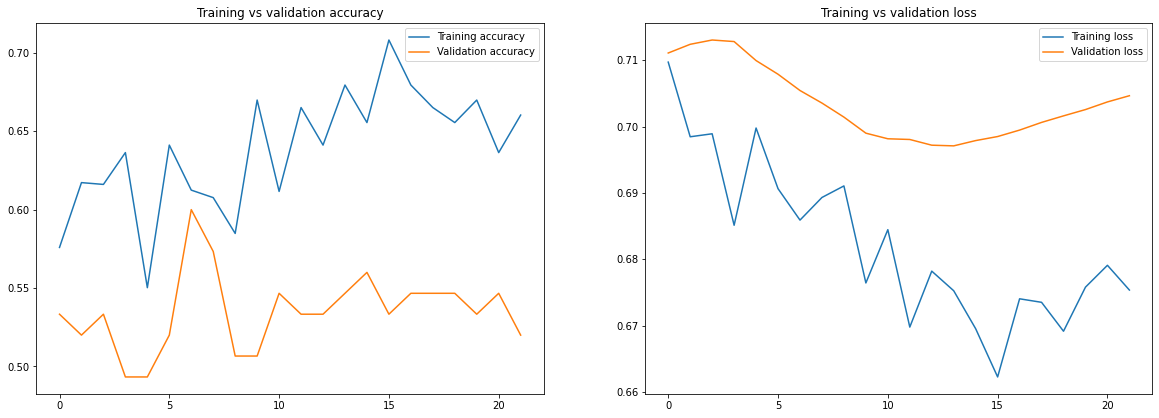

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H_Incep                            ##
pred_Dense = pred_Incep                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[28  7]
 [29 11]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.72 0.28]]


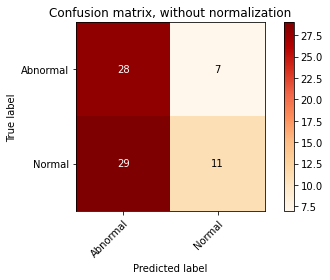

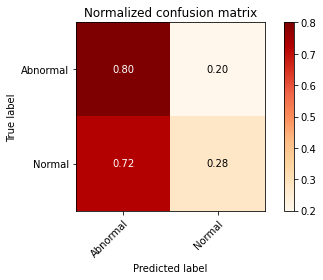

In [ ]:
y_pred = pred_Incep.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Incep)

print(classification_report(y_test_Incep.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Incep.classes_))

              precision    recall  f1-score   support

    Abnormal       0.55      0.74      0.63        35
      Normal       0.68      0.47      0.56        40

    accuracy                           0.60        75
   macro avg       0.62      0.61      0.60        75
weighted avg       0.62      0.60      0.59        75



Confusion matrix, without normalization
[[26  9]
 [21 19]]
Normalized confusion matrix
[[0.74 0.26]
 [0.53 0.47]]


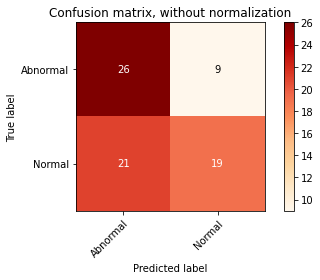

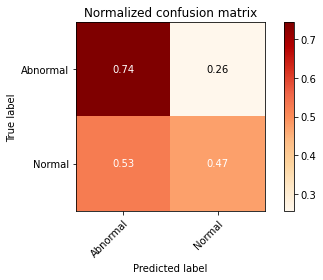

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Incep.argmax(axis=1)
y_test = y_test_Incep.argmax(axis=1)

class_names = le_Incep.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()